In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor

In [95]:
np.random.seed(123)

N = 10000 # number of units
K =  5 # number of covariates

# Generate random Xs
X_mu = np.zeros(5) # Means of Xs
# Random covariance matrix of Xs
X_sig = np.diag(np.random.rand(5))
# X_sig = np.random.rand(5, 5)
# X_sig = np.dot(X_sig, X_sig.transpose())
X = st.multivariate_normal(X_mu, X_sig).rvs(N)

# Effect of Xs on outcome
X_beta = np.random.uniform(0, 5, K)
# Effect of treatment on outcomes
D_beta = np.array([0, 1, 2])
# Effect of treatment on outcome conditional on X1
DX1_beta = np.array([0, 0, 3])

# Generate 3 treatments (randomly assigned, equal probability)
D1 = np.random.uniform(0, 1, N)
D = np.where(D1 <= 1/3, 0, np.where(D1 > 2/3,2, 1))
D_dum = pd.get_dummies(D)

# Generate Y (based on X, D, and random noise)
Y_sig = 1 # Variance of random outcome noise
Y = X @ X_beta + (D_dum @ D_beta) + X[:, 1] * (D_dum @ DX1_beta) + np.random.normal(0, Y_sig, N)
Y = Y.to_numpy()

In [96]:
# Split to training and validation
train_prop = .5
train_N = np.ceil(train_prop * N)
ind = np.array(range(N))
train_ind = np.random.choice(N, int(train_N), replace = False)
val_ind = ind[~np.isin(ind, train_ind)]

Xtrain, Dtrain, Ytrain = X[train_ind], D[train_ind], Y[train_ind]
Xval, Dval, Yval = X[val_ind], D[val_ind], Y[val_ind]

del X, D, Y

In [97]:
# Simple classifier and regressor for propensity, outcome, and cate
reg_t = RandomForestClassifier()
reg_y = GradientBoostingRegressor()
reg_cate = GradientBoostingRegressor()

In [241]:
import numpy as np
import pandas as pd
from statsmodels.api import OLS
from statsmodels.tools import add_constant
from sklearn.model_selection import cross_val_predict, StratifiedKFold

class DRtester:

    def __init__(
        self,
        reg_outcome,
        reg_t,
        n_splits=5
    ):
        self.reg_outcome = reg_outcome
        self.reg_t = reg_t
        self.n_splits = n_splits
        self.dr_train = None

    # Fits nusisance and CATE
    def fit_nuisance(
        self,
        Xval,
        Dval,
        yval,
        Xtrain = None,
        Dtrain = None,
        ytrain = None,
    ):

        self.tmts = np.sort(np.unique(Dval))

        # Number of treatments (excluding control)
        self.n_treat = len(self.tmts) - 1

        self.fit_on_train = (Xtrain is not None) and (Dtrain is not None) and (ytrain is not None)

        if self.fit_on_train:
            # Get DR outcomes in training sample
            reg_preds_train, prop_preds_train = self.fit_nuisance_cv(Xtrain, Dtrain, ytrain)
            self.dr_train = self.calculate_dr_outcomes(Dtrain, ytrain, reg_preds_train, prop_preds_train)

            # Get DR outcomes in validation sample
            reg_preds_val, prop_preds_val = self.fit_nuisance_train(Xtrain, Dtrain, ytrain, Xval)
            self.dr_val = self.calculate_dr_outcomes(Dval, yval, reg_preds_val, prop_preds_val)

        else:
            reg_preds_val, prop_preds_val = self.fit_nuisance_cv(Xval, Dval, yval)
            self.dr_val = self.calculate_dr_outcomes(Dval, yval, reg_preds_val, prop_preds_val)

        return self

    def fit_cate(self, reg_cate, Zval, Ztrain = None):
        if Ztrain is not None:
            self.cate_preds_train = self.fit_cate_cv(reg_cate, Ztrain, Dtrain, self.dr_train)
            self.cate_preds_val = self.fit_cate_train(reg_cate, Ztrain, Zval)
        else:
            self.cate_preds_val = self.fit_cate_cv(reg_cate, Zval, Dval, self.dr_val)

        return self


    def evaluate_cal(self, n_groups = 4):

        if self.dr_train is None:
            raise Exception("Must fit nuisance/CATE models on training sample data to use calibration test")

        self.cal_r_squared = np.zeros(self.n_treat)
        self.ate = np.zeros(self.n_treat)
        self.df_plot = pd.DataFrame()
        for k in range(self.n_treat):

            cuts = np.quantile(self.cate_preds_train[:, k], np.linspace(0, 1, n_groups + 1))
            probs = np.zeros(n_groups)
            g_cate = np.zeros(n_groups)
            se_g_cate = np.zeros(n_groups)
            gate = np.zeros(n_groups)
            se_gate = np.zeros(n_groups)
            for i in range(n_groups):
                # Assign units in validation set to groups
                ind = (self.cate_preds_val[:, k] >= cuts[i]) & (self.cate_preds_val[:, k] <= cuts[i + 1])
                # Proportion of validations set in group
                probs[i] = np.mean(ind)
                # Group average treatment effect (GATE) -- average of DR outcomes in group
                gate[i] = np.mean(self.dr_val[ind, k])
                se_gate[i] = np.std(self.dr_val[ind, k]) / np.sqrt(np.sum(ind))
                # Average of CATE predictions in group
                g_cate[i] = np.mean(self.cate_preds_val[ind, k])
                se_g_cate[i] = np.std(self.cate_preds_val[ind, k]) / np.sqrt(np.sum(ind))

            # Calculate overall ATE
            self.ate[k] = np.mean(self.dr_val[:, k])

            # Calculate group calibration score
            cal_score_g = np.sum(abs(gate - g_cate) * probs)
            # Calculate overall calibration score
            cal_score_o = np.sum(abs(gate - self.ate[k]) * probs)
            # Calculate R-square calibration score
            self.cal_r_squared[k] = 1 - (cal_score_g / cal_score_o)

            df_plot1 = pd.DataFrame({'ind': np.array(range(n_groups)),
                                     'gate': gate, 'se_gate': se_gate,
                                    'g_cate': g_cate, 'se_g_cate': se_g_cate})
            df_plot1['tmt'] = self.tmts[k + 1]
            self.df_plot = pd.concat((self.df_plot, df_plot1))

        return self

    def plot_cal(self, tmt):
        df = self.df_plot
        df = df[df.tmt == tmt].copy()
        rsq = round(self.cal_r_squared[np.where(self.tmts == tmt)[0][0] - 1], 3)
        df['95_err'] = 1.96 * df['se_gate']
        fig = df.plot(kind='scatter',
            x='g_cate',
            y='gate',
            yerr='95_err',
            xlabel = 'Group Mean CATE',
            ylabel = 'GATE',
            title=f"Treatment = {tmt}, Calibration R^2 = {rsq}")

        return fig

    def evaluate_blp(self):
        if self.n_treat == 1:  # binary treatment
            reg = OLS(self.dr_val, add_constant(self.cate_preds_val)).fit()
            params = [reg.params[1]]
            errs = [reg.bse[1]]
            pvals = [reg.pvalues[1]]
        else:  # categorical treatment
            params = []
            errs = []
            pvals = []
            for k in range(self.n_treat):  # run a separate regression for each
                reg = OLS(self.dr_val[:, k], add_constant(self.cate_preds_val[:, k])).fit(cov_type = 'HC1')
                params.append(reg.params[1])
                errs.append(reg.bse[1])
                pvals.append(reg.pvalues[1])

        self.blp_res = pd.DataFrame({'blp_est': params, 'blp_se': errs, 'blp_pval': pvals}, index = self.tmts[1:])
        self.blp_res =  self.blp_res.round({'blp_est': 3, 'blp_se':3, 'blp_pval': 3})
        # ['blp_pval'] = round(self.blp_res['blp_pval'], 3)

        return self



    def evaluate_all(self, n_groups = 4):

        self.evaluate_blp()
        self.df_res = self.blp_res

        if  self.fit_on_train:
            self.evaluate_cal(n_groups)
            self.df_res['cal_r_squared'] = np.around(self.cal_r_squared, 3)

        return self

    # Fits nuisance in train, predicts in validation
    def fit_nuisance_train(self, Xtrain, Dtrain, ytrain, Xval):

        # Fit propensity in treatment
        reg_t_fitted = self.reg_t.fit(Xtrain, Dtrain)
        # Predict propensity scores
        if self.n_treat == 1:
            prop_preds = reg_t_fitted.predict(Xval)
        else:
            prop_preds = reg_t_fitted.predict_proba(Xval)

        # Possible treatments (need to allow more than 2)
        tmts = np.sort(np.unique(Dtrain))
        n = Xval.shape[0]
        k = len(tmts)
        reg_preds = np.zeros((n, k))
        for i in range(k):
            reg_outcome_fitted = self.reg_outcome.fit(Xtrain[Dtrain == tmts[i]], ytrain[Dtrain == tmts[i]])
            reg_preds[:, i] = reg_outcome_fitted.predict(Xval)

        return reg_preds, prop_preds

    # CV nuisance predictions
    def fit_nuisance_cv(self, X, D, y, shuffle=True, random_state=123):

        cv = StratifiedKFold(n_splits=self.n_splits, shuffle=shuffle, random_state=random_state)
        splits = list(cv.split(X, D))


        if self.n_treat == 1:
            prop_preds = cross_val_predict(reg_t, X, D, cv=splits)
        else:
            prop_preds = cross_val_predict(reg_t, X, D, cv=splits, method='predict_proba')


        # Predict outcomes
        # T-learner logic
        tmts = np.sort(np.unique(D))
        N = X.shape[0]
        K = len(tmts)
        reg_preds = np.zeros((N, K))
        for k in range(K):
            for train, test in splits:
                reg_outcome_fitted = self.reg_outcome.fit(X[train][D[train] == tmts[k]], y[train][D[train] == tmts[k]])
                reg_preds[test, k] = reg_outcome_fitted.predict(X[test])

        return reg_preds, prop_preds

    # Calculates DR outcomes
    def calculate_dr_outcomes(
        self,
        D: np.array,
        y: np.array,
        reg_preds,
        prop_preds
    ) -> np.array:

        if self.n_treat == 1:  # if treatment is binary
            reg_preds_chosen = np.sum(reg_preds * np.column_stack((D, 1 - D)), axis=1)

            # Calculate doubly-robust outcome
            dr = reg_preds[:, 1] - reg_preds[:, 0]
            # Reiz representation, clip denominator at 0.01
            reisz = (D - prop_preds) / np.clip(prop_preds * (1 - prop_preds), .01, np.inf)
            dr += (y - reg_preds_chosen) * reisz
        else:  # if treatment is categorical
            # treat each treatment as a separate regression
            # here, prop_preds should be a matrix
            # with rows corresponding to units and columns corresponding to treatment statuses
            dr_vec = []
            d0_mask = np.where(D == 0, 1, 0)
            y_dr_0 = reg_preds[:, 0] + (d0_mask / np.clip(prop_preds[:, 0], .01, np.inf)) * (y - reg_preds[:, 0])
            for k in np.sort(np.unique(D)):  # pick a treatment status
                if k > 0:  # make sure it is not control
                    dk_mask = np.where(D == k, 1, 0)
                    y_dr_k = reg_preds[:, k] + (dk_mask / np.clip(prop_preds[:, k], .01, np.inf)) * (y - reg_preds[:, k])
                    dr_k = y_dr_k - y_dr_0  # this is an n x 1 vector
                    dr_vec.append(dr_k)
            dr = np.column_stack(dr_vec)  # this is an n x k matrix

        return dr

    def cate_fit_predict(self, reg_cate, train, test, dr):

        if np.ndim(test) == 1:
            test = test.reshape(-1, 1)

        if np.ndim(train) == 1:
            train = train.reshape(-1, 1)

        if self.n_treat == 1:
            reg_cate_fitted = reg_cate.fit(train, dr)
            cate_preds = reg_cate_fitted.predict(test)
        else:
            cate_preds = []
            for k in range(self.n_treat):  # fit a separate cate model for each treatment status?
                reg_cate_fitted = reg_cate.fit(train, dr[:, k])
                cate_preds.append(reg_cate_fitted.predict(test))

            cate_preds = np.column_stack(cate_preds)

        return cate_preds

    # Fits CATE in training, predicts in validation
    def fit_cate_train(self, reg_cate, Ztrain, Zval):
        return self.cate_fit_predict(reg_cate, Ztrain, Zval, self.dr_train)

    # CV prediction of CATEs
    def fit_cate_cv(self, reg_cate, Z, D, dr, shuffle=True, random_state=712):
        cv = StratifiedKFold(n_splits=self.n_splits, shuffle=shuffle, random_state=random_state)
        splits = list(cv.split(Z, D))

        if np.ndim(Z) == 1:
            Z = Z.reshape(-1, 1)

        N = Z.shape[0]
        tmts = np.sort(np.unique(D))
        K = len(tmts)
        cate_preds = np.zeros((N, K - 1))

        for k in range(K - 1):
            cate_preds[:, k] = cross_val_predict(reg_cate, Z, dr[:, k], cv = splits)

        return cate_preds


In [242]:
my_dr_tester = DRtester(reg_y, reg_t).fit_nuisance(Xval, Dval, Yval, Xtrain, Dtrain, Ytrain)

In [243]:
Ztrain = Xtrain[:, 1]
Zval = Xval[:, 1]
my_dr_tester = my_dr_tester.fit_cate(reg_cate, Zval, Ztrain)

In [244]:
my_dr_tester = my_dr_tester.evaluate_all()

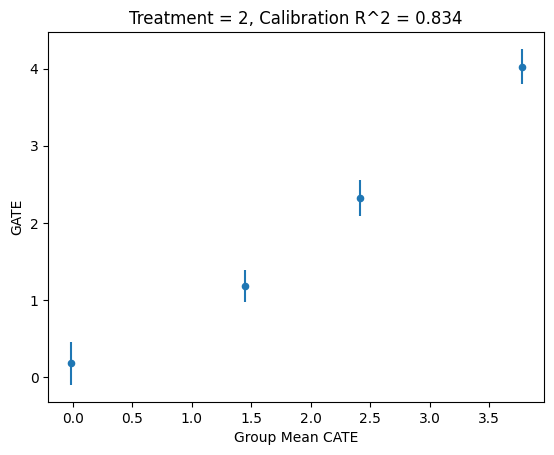

In [245]:
fig = my_dr_tester.plot_cal(2)

In [246]:
my_dr_tester.df_res

,blp_est,blp_se,blp_pval,cal_r_squared
1,-0.035,0.051,0.499,-2.747
2,0.814,0.090,0.000,0.834


In [223]:
my_dr_tester = DRtester(reg_y, reg_t).fit_nuisance(Xval, Dval, Yval)

Zval = Xval[:, 1]
my_dr_tester = my_dr_tester.fit_cate(reg_cate, Zval)

In [224]:
my_dr_tester = my_dr_tester.evaluate_cal()

Exception: Must fit nuisance/CATE on training sample data to use calibration test

In [166]:
my_dr_tester = DRtester(reg_y, reg_t)
Ztrain = Xtrain[:, 1]
Zval = Xval[:, 1]
my_dr_tester = my_dr_tester.fit(reg_cate, Xval, Dval, Yval, Zval, Xtrain, Dtrain, Ytrain, Ztrain)
my_dr_tester = my_dr_tester.evaluate_cal(4)

In [210]:
df = my_dr_tester.df_plot

<Axes: title={'center': 'Calibration R^2 = -1.647'}, xlabel='Group Mean CATE', ylabel='GATE'>

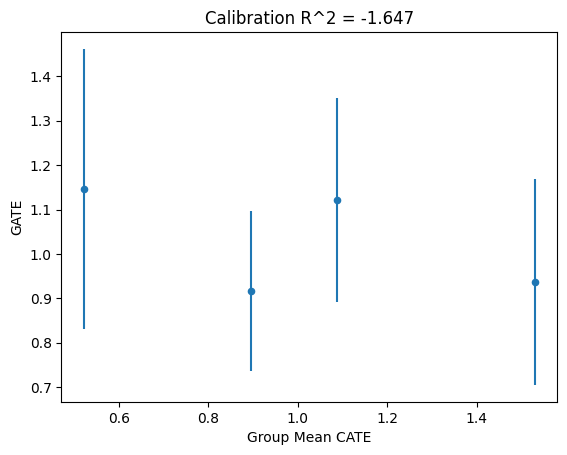

In [172]:
# Fit on train method
my_dr_tester = DRtester(reg_y, reg_t)

Ztrain = Xtrain[:, 1]
Zval = Xval[:, 1]
my_dr_tester = my_dr_tester.fit(reg_cate, Xval, Dval, Yval, Zval, Xtrain, Dtrain, Ytrain, Ztrain).evaluate_blp()

In [65]:
# # Test that DR outcomes is working (get right ATE)
# print('Testing DR outcomes performance')
# print('Treatment 1: True =', D_beta[1], ', Estimate = ', round(np.mean(my_dr_tester.dr_val[:, 0]), 3))
# print('Treatment 2: True =', D_beta[2], ', Estimate = ', round(np.mean(my_dr_tester.dr_val[:, 1]), 3))
#
# # Test DR outcomes are working (correct heterogeneity)
# het_est1 = round(OLS(my_dr_tester.dr_val[:, 0], add_constant(Xval[:, 1])).fit().params[1], 3)
# print('Treatment 1 Heterogeneity: True =', DX1_beta[1], ', Estimate =', het_est1)
# het_est2 = round(OLS(my_dr_tester.dr_val[:, 1], add_constant(Xval[:, 1])).fit().params[1], 3)
# print('Treatment 2 Heterogeneity: True =', DX1_beta[2], ', Estimate =', het_est2, '\n')
#
# print(my_dr_tester.blp_res)
#
# # print(round(O)
# # print(OLS(my_dr_tester.dr_val[:, 1], add_constant(Xval[:, 1])).fit().params[1])

Testing DR outcomes performance
Treatment 1: True = 1 , Estimate =  1.008
Treatment 2: True = 2 , Estimate =  1.98
Treatment 1 Heterogeneity: True = 0 , Estimate = -0.05
Treatment 2 Heterogeneity: True = 3 , Estimate = 2.899 

   Estimate  Std. Err        p-Value
0 -0.267141  0.179176   1.359756e-01
1  0.917155  0.040256  6.737735e-115


In [174]:
# Fit on train method
my_dr_tester = DRtester(reg_y, reg_t)

Ztrain = Xtrain[:, 1]
Zval = Xval[:, 1]
my_dr_tester = my_dr_tester.fit(reg_cate, Xval, Dval, Yval, Zval, Xtrain, Dtrain, Ytrain, Ztrain).evaluate_blp()

In [175]:
# Test that the ATEs are correct
tol = .2
print((abs(D_beta[1] - np.mean(my_dr_tester.dr_val[:, 0])) <= tol) & (abs(D_beta[2] - np.mean(my_dr_tester.dr_val[:, 1])) <= tol))

# Test that there is no heterogenity in the first treatment
print(my_dr_tester.blp_res['p-Value'][0] >= .05)

# Test that there is significant heterogeneity in second treatment
print(my_dr_tester.blp_res['p-Value'][1] < .05)

True
True
True


In [176]:
# Make sure when using the wrong covariate for the CATE that it is not significant
Ztrain = Xtrain[:, 2]
Zval = Xval[:, 2]
my_dr_tester = my_dr_tester.fit(reg_cate, Xval, Dval, Yval, Zval, Xtrain, Dtrain, Ytrain, Ztrain).evaluate_blp()

print((my_dr_tester.blp_res['p-Value'][0] >= .05) & (my_dr_tester.blp_res['p-Value'][1] >= .05))

True


In [92]:
np.

,Estimate,Std. Err,p-Value
0,0.336239,0.136832,0.013998
1,-0.047671,0.111882,0.670048


True

False

True

In [117]:
# Fit on validation method
Ztrain = Xtrain[:, 1]
Zval = Xval[:, 1]
my_dr_tester = my_dr_tester.fit(reg_cate, Xval, Dval, Yval, Zval).evaluate_blp()

In [118]:
tol = .2

In [119]:
# Test that the ATEs are correct
print((abs(D_beta[1] - np.mean(my_dr_tester.dr_val[:, 0])) <= tol) & (abs(D_beta[2] - np.mean(my_dr_tester.dr_val[:, 1])) <= tol))

# Test that there is no heterogenity in the first treatment
print(my_dr_tester.blp_res['p-Value'][0] >= .05)

# Test that there is significant heterogeneity in second treatment
print(my_dr_tester.blp_res['p-Value'][1] < .05)

# Make sure when using the wrong covariate for the CATE that it is not significant
# Ztrain = Xtrain[:, 2]
# Zval = Xval[:, 2]
# my_dr_tester = my_dr_tester.fit(reg_cate, Xval, Dval, Yval, Zval, Xtrain, Dtrain, Ytrain, Ztrain).evaluate_blp()
#
# print((my_dr_tester.blp_res['p-Value'][0] >= .05) & (my_dr_tester.blp_res['p-Value'][1] >= .05))

True
False
True


In [121]:
my_dr_tester.blp_res

,Estimate,Std. Err,p-Value
0,-0.300900,0.127902,1.864359e-02
1,0.828916,0.051007,2.196256e-59


In [109]:
(abs(D_beta[1] - np.mean(my_dr_tester.dr_val[:, 0])) <= .05)

True

In [115]:
np.std(my_dr_tester.dr_val[:, 1]) / np.sqrt(N) * 1.96

0.0868759675127867

In [110]:
(abs(D_beta[2] - np.mean(my_dr_tester.dr_val[:, 1])) <= .05)

False

In [111]:
np.mean(my_dr_tester.dr_val[:, 1])

1.8771407030589031

In [54]:
# Test that DR outcomes is working (get right ATE)
print('Testing DR outcomes performance')
print('Treatment 1: True =', D_beta[1], ', Estimate = ', round(np.mean(my_dr_tester.dr_val[:, 0]), 3))
print('Treatment 2: True =', D_beta[2], ', Estimate = ', round(np.mean(my_dr_tester.dr_val[:, 1]), 3))

# Test DR outcomes are working (correct heterogeneity)
het_est1 = round(OLS(my_dr_tester.dr_val[:, 0], add_constant(Xval[:, 1])).fit().params[1], 3)
print('Treatment 1 Heterogeneity: True =', DX1_beta[1], ', Estimate =', het_est1)
het_est2 = round(OLS(my_dr_tester.dr_val[:, 1], add_constant(Xval[:, 1])).fit().params[1], 3)
print('Treatment 2 Heterogeneity: True =', DX1_beta[2], ', Estimate =', het_est2, '\n')

# Testing BLP (first should be 0)
print(my_dr_tester.blp_res)

Testing DR outcomes performance
Treatment 1: True = 1 , Estimate =  1.064
Treatment 2: True = 2 , Estimate =  2.067
Treatment 1 Heterogeneity: True = 0 , Estimate = -0.132
Treatment 2 Heterogeneity: True = 3 , Estimate = 2.931 

   Estimate  Std. Err        p-Value
0  0.076571  0.018189   2.601755e-05
1  0.444957  0.015868  8.035600e-161
